In [6]:
#!conda env list

## 1 Set API Key

In [7]:
import os
from openai import OpenAI 

## Set the API key and model name
MODEL="gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")
client = OpenAI(api_key=api_key)

### 1.1 Try out functionality

In [8]:
completion = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "user", "content": "You are a helpful recruiting assistant. We have a list of candidates we want to interview for a job and we want to tailor interview questions to their skills."}, # <-- This is the system message that provides context to the model
    {"role": "system", "content": f"Hello! Based on the following candidates:, could you make a list of 5 interview questions for all of them based on their total pool of skills and how it relates to the skills required of the job - here:  "}  # <-- This is the user message for which the model will generate a response
  ]
)

In [9]:
from IPython.display import display, Markdown, Latex
display(Markdown(completion.choices[0].message.content))

Sure! Please provide me with the list of candidates and their skills, as well as the job requirements so that I can tailor the interview questions accordingly.

### 1.2 Create Dataframe with Job Descriptions

In [6]:
ls

LICENSE                comparison.ipynb       source/
LLM.ipynb              environment.yml        synthetic_data.ipynb
README.md              environment_mac.yml    user_interface/
Resources/             job_descriptions/      word_embeddings.ipynb
__pycache__/           main.py
agenda.md              services/


In [10]:
import os
import pandas as pd

job_descriptions_path = 'job_descriptions/'
files = [f for f in os.listdir(job_descriptions_path) if f.endswith('.txt')]
jobs = []

for i, filename in enumerate(files):
    with open(os.path.join(job_descriptions_path, filename), 'r', encoding='utf-8') as f:
        content = f.read().strip()
        
        # If the Job Title is the first line of the file
        lines = content.split('\n')
        job_title = lines[0]  # Assuming the first line is the Job Title
        jd = '\n'.join(lines[1:])  # The rest is the Job Description
        
        # If the Job Title is derived from the filename instead, uncomment the next line
        # job_title = os.path.splitext(filename)[0]  # Filename without extension
        
        jobs.append({
            'Job ID': i + 1,
            'Job Title': job_title,
            'JD': jd
        })

df_jobs = pd.DataFrame(jobs)
df_jobs

,Job ID,Job Title,JD
0,1,,
1,2,,
2,3,,
3,4,,
4,5,,
5,6,"Machine Learning Engineer, Sage, London",\nFull job description\n\nAbout our Team:\nThe...
6,7,,
7,8,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
8,9,Data Scientist,Lisbon\n\n\n\nApply on employer site\n\n\nAppl...
9,10,Junior Data Engineer,"At Capgemini Engineering, the world leader in ..."


In [11]:
job_titles_to_keep = [
    'Senior Data Scientist, WTW, London',
    'Software Engineer II, Android, Microsoft, London'
]

df_filtered = df_jobs[df_jobs['Job Title'].isin(job_titles_to_keep)].reset_index(drop=True)
df_filtered['Job ID'] = df_filtered.index + 1
df_filtered

,Job ID,Job Title,JD
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...
1,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...


## 2 Synthetic Data Generation

### 2.1 First try with 5 Buckets (2 JDs a 5 CVs)

In [8]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Define the matching score buckets and corresponding scores
score_buckets = {
    '0.0 - 0.2': 0.1,
    '0.2 - 0.4': 0.3,
    '0.4 - 0.6': 0.5,
    '0.6 - 0.8': 0.7,
    '0.8 - 1.0': 0.9
}

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Iterate over each score bucket
    for bucket_label, score in score_buckets.items():
        # System message providing context (as 'user' role)
        system_message = {
            "role": "user",
            "content": """
You are an AI assistant that generates realistic resumes for candidates in the tech sector.
The score indicates the level of match between the resume and the job description with a higher score indicating a better match of skills between the resume and the job description.
Do not base decisions on education, experience levels, or job titles alone.
"""
        }
        
        # User message with specific instructions (as 'system' role)
        user_message = {
            "role": "system",
            "content": f"""
**Task:**

For the following job description, generate a unique resume of an individual applicant from the tech sector.
The resume should have a matching score of **{score}**, which falls within the **{bucket_label}** bucket.

**Instructions:**

- The matching score should accurately reflect the level of match between the job description and the generated resume, with a higher score indicating a better match between the resume and the job description.
- Use a combination of skills, diverse industry project experiences, education, and certifications to create realistic resume data.
- Incorporate realistic KPIs to make work experience realistic.
- Do not include any notes or explanations about how the resume was generated.
- The resume should be between **200 and 500 words**.
- Create resumes only for applicants from the tech sector.

**Job Description:**

{job_description}

**Output Format:**

Provide the resume in plain text. Do not include the matching score in the resume.
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{int(score*10)}",
            'CV name': f"Candidate_{job_id}_{int(score*10)}",
            'CV': resume_text,
            'Label Matching Score': score
        })

# Create a DataFrame from the list of generated resumes
df_resumes = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Label Matching Score
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,"**John Smith** \n123 Tech Lane \nLondon, UK ...",0.1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,"**John Doe** \nLondon, UK \njohn.doe@email.c...",0.3
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,"**John Doe** \nLondon, UK \njohn.doe@email.c...",0.5
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_7,Candidate_1_7,"**John Doe** \n123 Tech Lane \nLondon, UK \...",0.7
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_9,Candidate_1_9,"**John Smith** \nLondon, United Kingdom \njo...",0.9
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,"**John Doe** \n123 Tech Lane \nLondon, UK \...",0.1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,"**John Doe** \nLondon, UK \njohn.doe@email.c...",0.3
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,"**John Doe** \nLondon, UK \njohn.doe@email.c...",0.5
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_7,Candidate_2_7,"**John Doe** \n123 Tech Lane \nLondon, UK \...",0.7
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_9,Candidate_2_9,"**John Doe** \nLondon, UK \njohn.doe@email.c...",0.9


**System Message:**

You are an AI language model specializing in generating realistic resumes for candidates in the tech sector. Focus on a skills-first approach when creating resumes, emphasizing the applicant’s technical skills relevant to the job description. Do not base the suitability of the candidate on education, experience levels, or job titles alone. Ensure that all resumes are for tech industry applicants. Each resume should be between 200 and 500 words, without any additional notes or explanations.

**User Message:**

Task:
For the given job description, generate five unique resumes of applicants from the tech sector. Each resume should score differently on a matching scale between 0 (no fit) and 1 (perfect fit). Allocate one resume to each of the following score buckets by setting a score within the bucket range:

- 0.0 - 0.2: No fit / Rejected
- 0.2 - 0.4: Bad fit / Rejected
- 0.4 - 0.6: Medium fit / Rejected after first assessment
- 0.6 - 0.8: Good fit / Rejected due to better options
- 0.8 - 1.0: Perfect fit / Hired

Instructions:
- Use a combination of skills, diverse industry project experiences, education, and certifications to create realistic resume data.
- Incorporate realistic KPIs to enhance work experience details.
- Do not include any notes or explanations about how the resumes were generated.
- Each resume should be between 200 and 500 words.

Job Description:
[Insert the job description for either “Senior Data Scientist, WTW, London” or “Software Engineer II, Android, Microsoft, London” here.]

Output Format:
Provide the resumes in plain text, clearly separating each one. At the beginning of each resume, indicate the matching score bucket it falls into (e.g., “Matching Score: 0.4 - 0.6”).

Example:
To give you an idea of how the AI might structure the output:

Matching Score: 0.1

Resume for Candidate A…

Matching Score: 0.3

Resume for Candidate B…

(And so on for each score bucket.)

Additional Tips:
- Consistency: Ensure that the AI understands the importance of aligning each resume with the specified matching score bucket by varying the relevance of skills and experiences to the job description.
- Relevance: For higher matching scores, the resumes should closely match the skills and requirements outlined in the job description. For lower scores, the resumes should lack key skills or have irrelevant experience.
- Privacy Compliance: Make sure that the generated resumes do not include any real personal data or identifiable information.

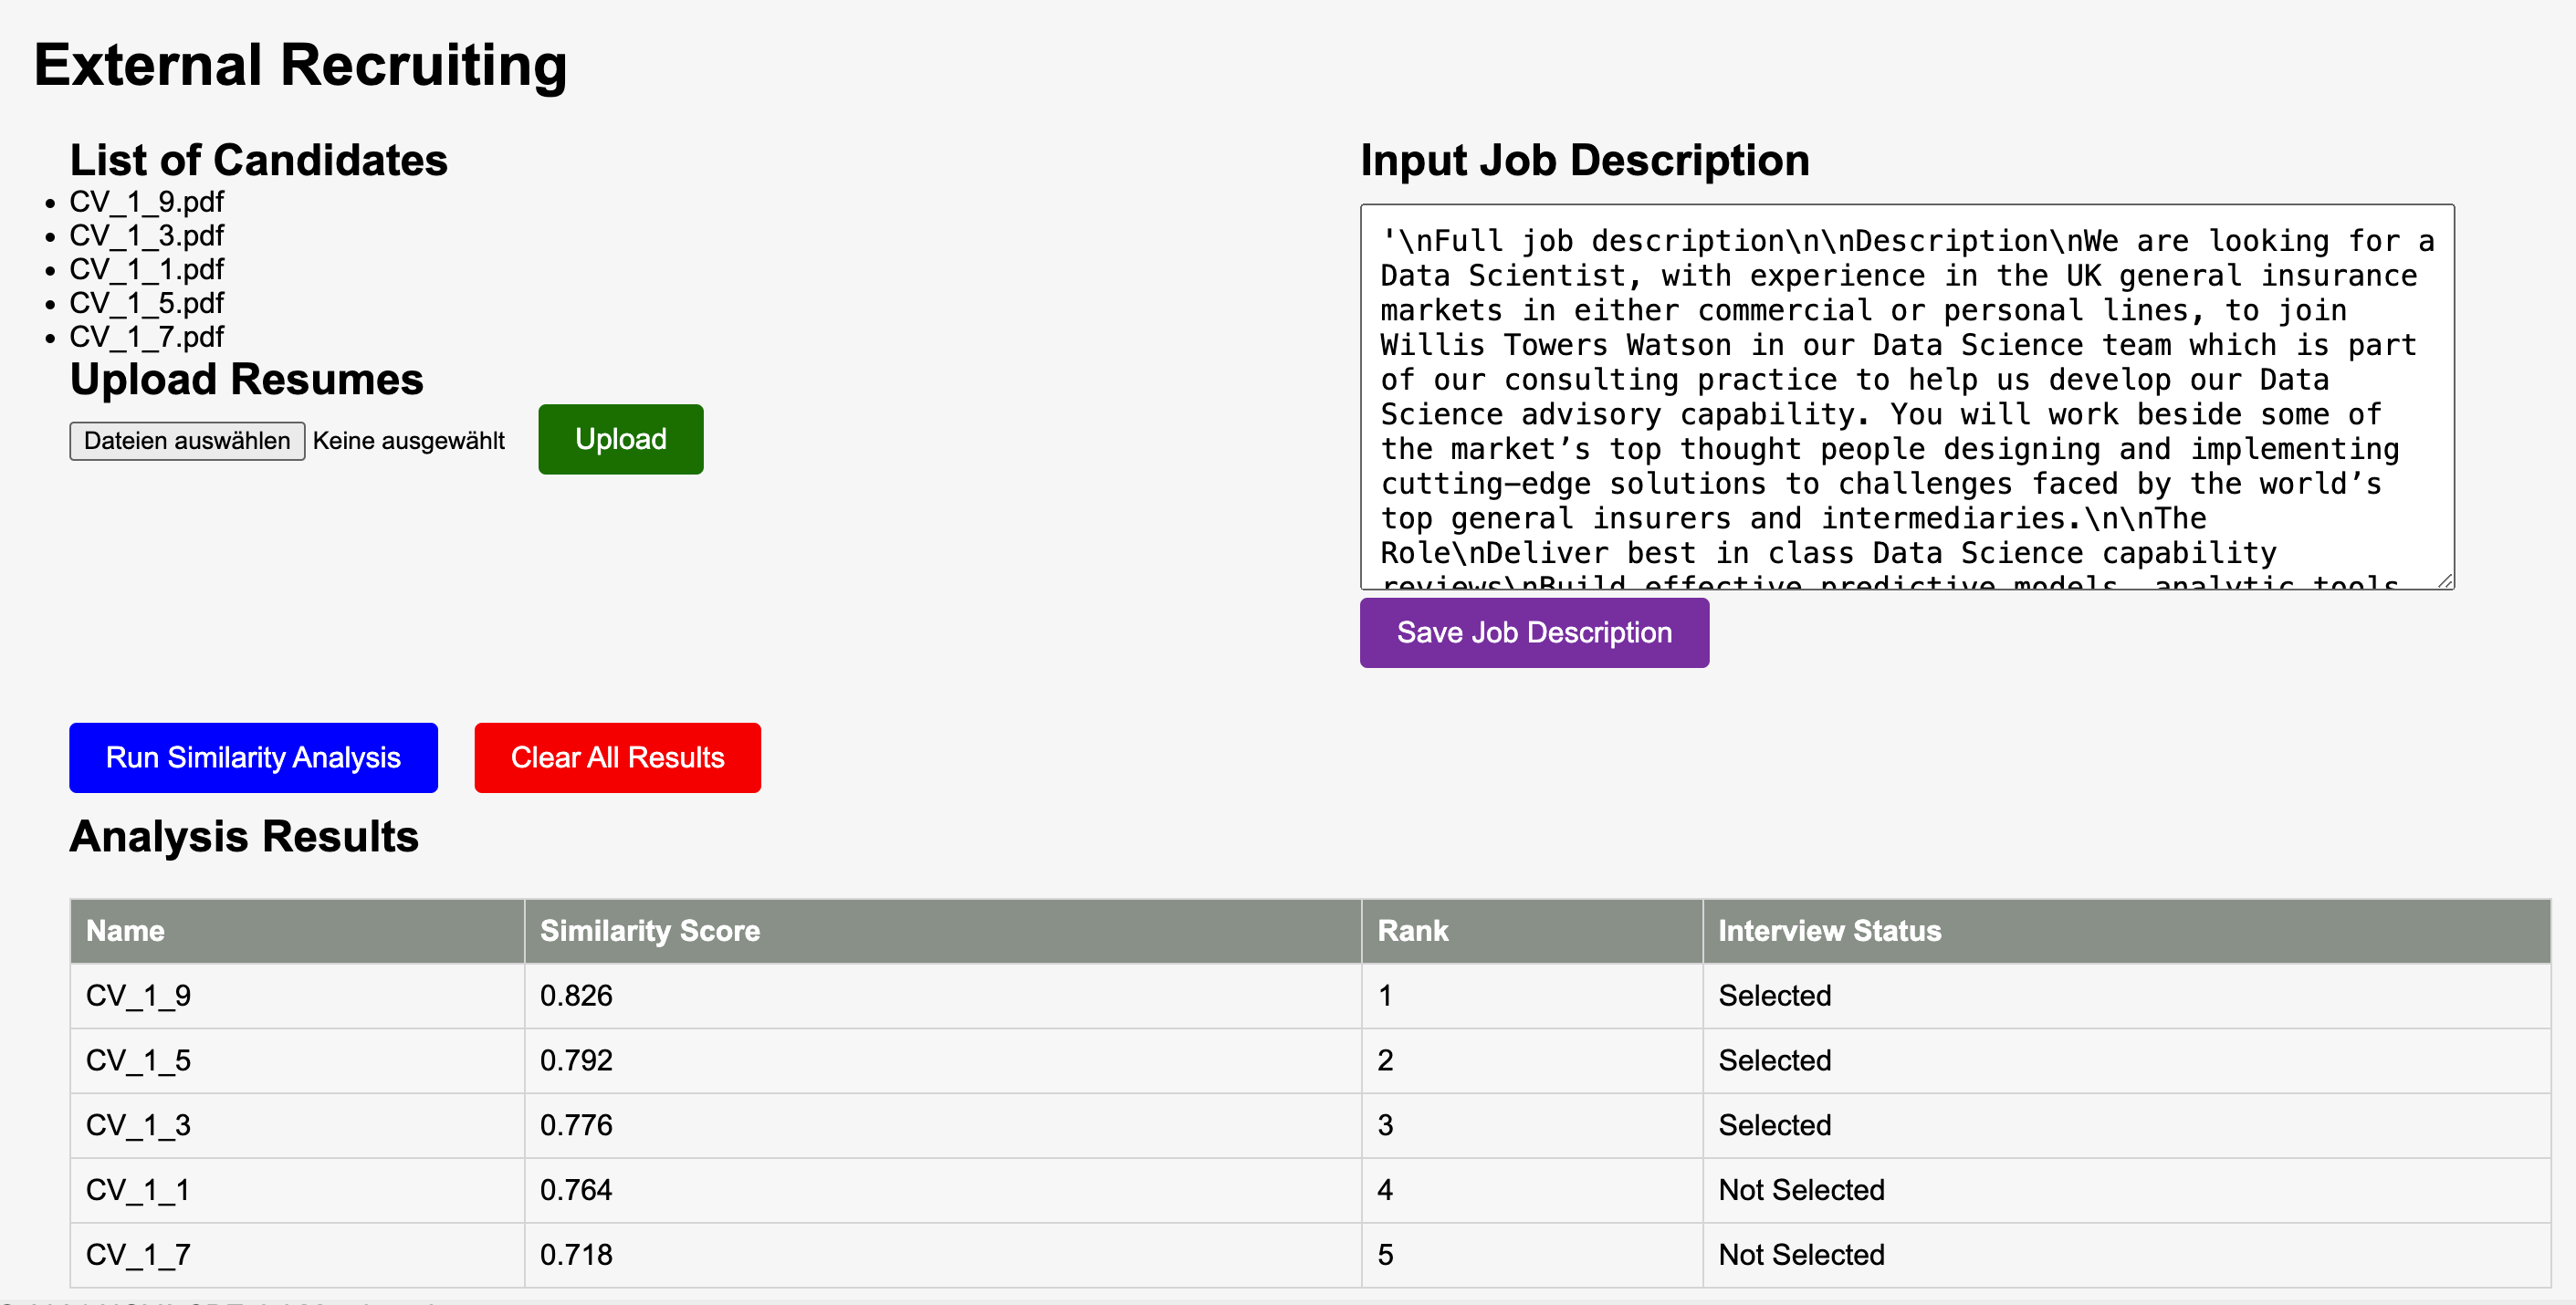

### 2.2 Second Try with Ranking CVs (2 JDs a 5 CVs)

In [11]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Iterate over ranks 1 to 5
    for rank in range(1, 6):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are an AI assistant that generates realistic resumes for candidates in the tech sector.  
The goal is to simulate varying levels of fit between candidates and the provided job description based on a ranking system from 1 to 5, where:  
- **1 = Best Fit** (high alignment of skills and hidden skills patterns).  
- **5 = Lowest Fit** (minimal alignment and weak skill patterns).  

The ranking should depend on a **skills-first approach**, measuring:  
- **Alignment of skills**: How well the applicant’s skills match the skills required in the job description.  
- **Relation of skills**: How well the applicant’s skills complement the required skills and reveal meaningful hidden patterns that indicate a better fit.  

The ranking **must not depend** on:  
- Level of education.  
- Grades.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
**Task:**

For the following job description, generate a unique resume of an individual applicant from the tech sector.
Assign a **ranking from 1 to 5** to the resume based on the following criteria:

**Ranking Criteria:**
1. **Best Fit (Rank 1):**
   - Skills are highly aligned with the job description, including strong direct matches (explicit skills overlap) and complementary skills (implicit patterns).
   - The resume demonstrates high relevance and depth in key skills critical for the job.

2. **Good Fit (Rank 2):**
   - Skills align well, with a mix of direct matches and complementary skills, but slightly less breadth or depth than Rank 1.

3. **Moderate Fit (Rank 3):**
   - Skills cover some relevant areas but may lack depth in critical skills or show limited complementary patterns.

4. **Low Fit (Rank 4):**
   - Few skills align directly with the job, and the complementary patterns are weak or incomplete.

5. **Lowest Fit (Rank 5):**
   - Minimal alignment with the job description, with significant gaps in required skills and little to no complementary patterns.

**Instructions:**
- Create realistic resumes for diverse individuals with:
  - Industry-relevant skills.
  - Diverse project experiences and certifications.
  - Unique names and individualized experiences.
  - Realistic KPIs and achievements to validate work experience.

- Simulate complex relationships between skills, avoiding reliance on simple keyword matches.
- Ensure higher-ranked resumes demonstrate clear progression in skill alignment, relevance, and relation. Lower-ranked resumes should show clear gaps or mismatches.

**Output Requirements:**
- The resume should be between **350-500 words**.
- Avoid explanatory notes or references to the ranking process.
- End the resume with a line indicating the rank: **Rank: {rank}**.

**Job Description:**

{job_description}

**Output Format:**

Provide the resume in plain text. Do not include the matching score in the resume.
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{rank}",
            'CV name': f"Candidate_{job_id}_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes2 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes2

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,**Johnathan Cooper** \nData Scientist \nLond...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_2,Candidate_1_2,"**Jane Thompson** \nLondon, United Kingdom \...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,**Johnathan Smith** \nData Scientist \nLondo...,3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_4,Candidate_1_4,"**John Doe** \nLondon, UK \njohn.doe@email.c...",4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,"**Johnathan H. Mitchell** \nLondon, UK \njoh...",5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,"**Johnathan Rivers** \nLondon, UK \njohnatha...",1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_2,Candidate_2_2,"**Jordan McKinney** \nLondon, UK \njordan.mc...",2
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,"**John Doe** \nLondon, UK \njohn.doe@email.c...",3
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_4,Candidate_2_4,"**John Smith** \nLondon, UK \nEmail: john.sm...",4
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,"**Jordan Elms** \nLondon, UK \njordan.elms@e...",5


In [13]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/cvs synthetic it.2"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes2.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=917eada627dea55a883dcf3523904b01e392b85cc1f8b42c450fdafe01d41283
  Stored in directory: /Users/timg/Library/Caches/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


**Performance:**

Results are far from what we aim for.
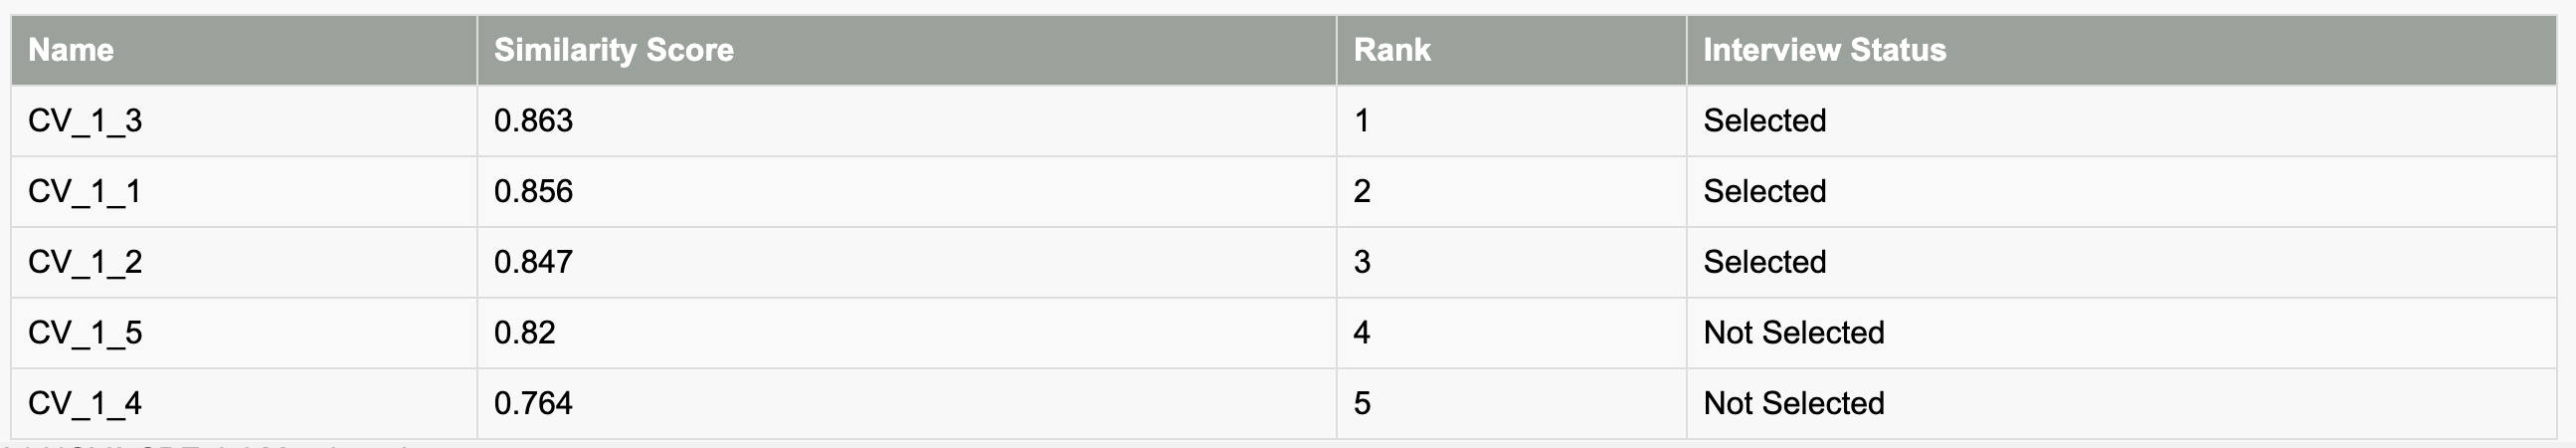

*Reasoning:*
- CVs are ranked in random order
- CVs are all within the upper bound of similarity indicating that all CVs are a decent match with the job description

*Next Steps:*
- Analyze chats understanding of a good or bad fit by adding an explanation to each resume

In [15]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Iterate over ranks 1 to 5
    for rank in range(1, 6):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are an AI assistant that generates realistic resumes for candidates in the tech sector.  
The goal is to simulate varying levels of fit between candidates and the provided job description based on skill alignment.
The level of fit should be indicated by numbers from 1 to 5, where:
- **1 = Best Fit** (high alignment of skills and related skills between resume and job description).
- **5 = Lowest Fit** (minimal alignment of skills and related skills between resume and job description).

The ranking **must not depend** on:  
- Level of education.  
- Grades.
- Job titles.
- Work experience.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
**Task:**

For the following job description, generate a unique resume of an individual applicant from the tech sector.
Assign a **ranking from 1 to 5** to the resume based on the following criteria:

**Ranking Criteria:**
1. **Best Fit (Rank 1):**
   - Skills are highly aligned with the job description, including strong direct matches (explicit skills overlap) and complementary skills (implicit patterns).
   - The resume demonstrates high relevance and depth in key skills critical for the job.

2. **Good Fit (Rank 2):**
   - Skills align well, with a mix of direct matches and complementary skills, but slightly less breadth or depth than Rank 1.

3. **Moderate Fit (Rank 3):**
   - Skills cover some relevant areas but may lack critical skills or show limited complementary patterns.

4. **Low Fit (Rank 4):**
   - Few skills align directly with the job, and the complementary patterns are weak or incomplete.

5. **Lowest Fit (Rank 5):**
   - Minimal alignment with the job description, with significant gaps in required skills and little to no complementary patterns.

**Instructions:**
- Create realistic resumes for diverse individuals with:
  - Skills relevant for the technology sector.
  - Diverse project experiences and certifications.
  - Unique names and individualized experiences.
  - Realistic KPIs and achievements to validate work experience.
- Ensure higher-ranked resumes demonstrate clear progression in skill alignment, relevance, and relation. Lower-ranked resumes should show clear gaps or mismatches.

**Output Requirements:**
- The resume should be between **350-500 words**.
- At the bottom, include bullet points explaining why the resume ranked the way it does.
- End the resume with a line indicating the rank: **Rank: {rank}**.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{rank}",
            'CV name': f"Candidate_{job_id}_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes3 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes3

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,"**Resume**\n\n**John Anderson** \nLondon, UK ...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_2,Candidate_1_2,**Resume**\n\n**Name:** Emma Lancaster \n**Co...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,**Resume:**\n\n**Name:** Emily W. Thompson \n...,3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_4,Candidate_1_4,**Resume**\n\n**Name:** Sarah Collins \n**Loc...,4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,**Resume**\n\n**Name**: Hilda Jennings \n**Co...,5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,"**Johnathan Smith** \nLondon, UK \nEmail: jo...",1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_2,Candidate_2_2,"**Resume:**\n\n**Johnathon Smith** \nLondon, ...",2
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,**Resume** \n**Name:** Sarah Johnson \n**Con...,3
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_4,Candidate_2_4,**Resume**\n\n**Name:** Sarah Thompson \n**Lo...,4
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,"**John Doe** \n123 Silicon Avenue \nLondon, ...",5


In [16]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/cvs synthetic it.2"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_2"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes3.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

**Interpretation of results:**

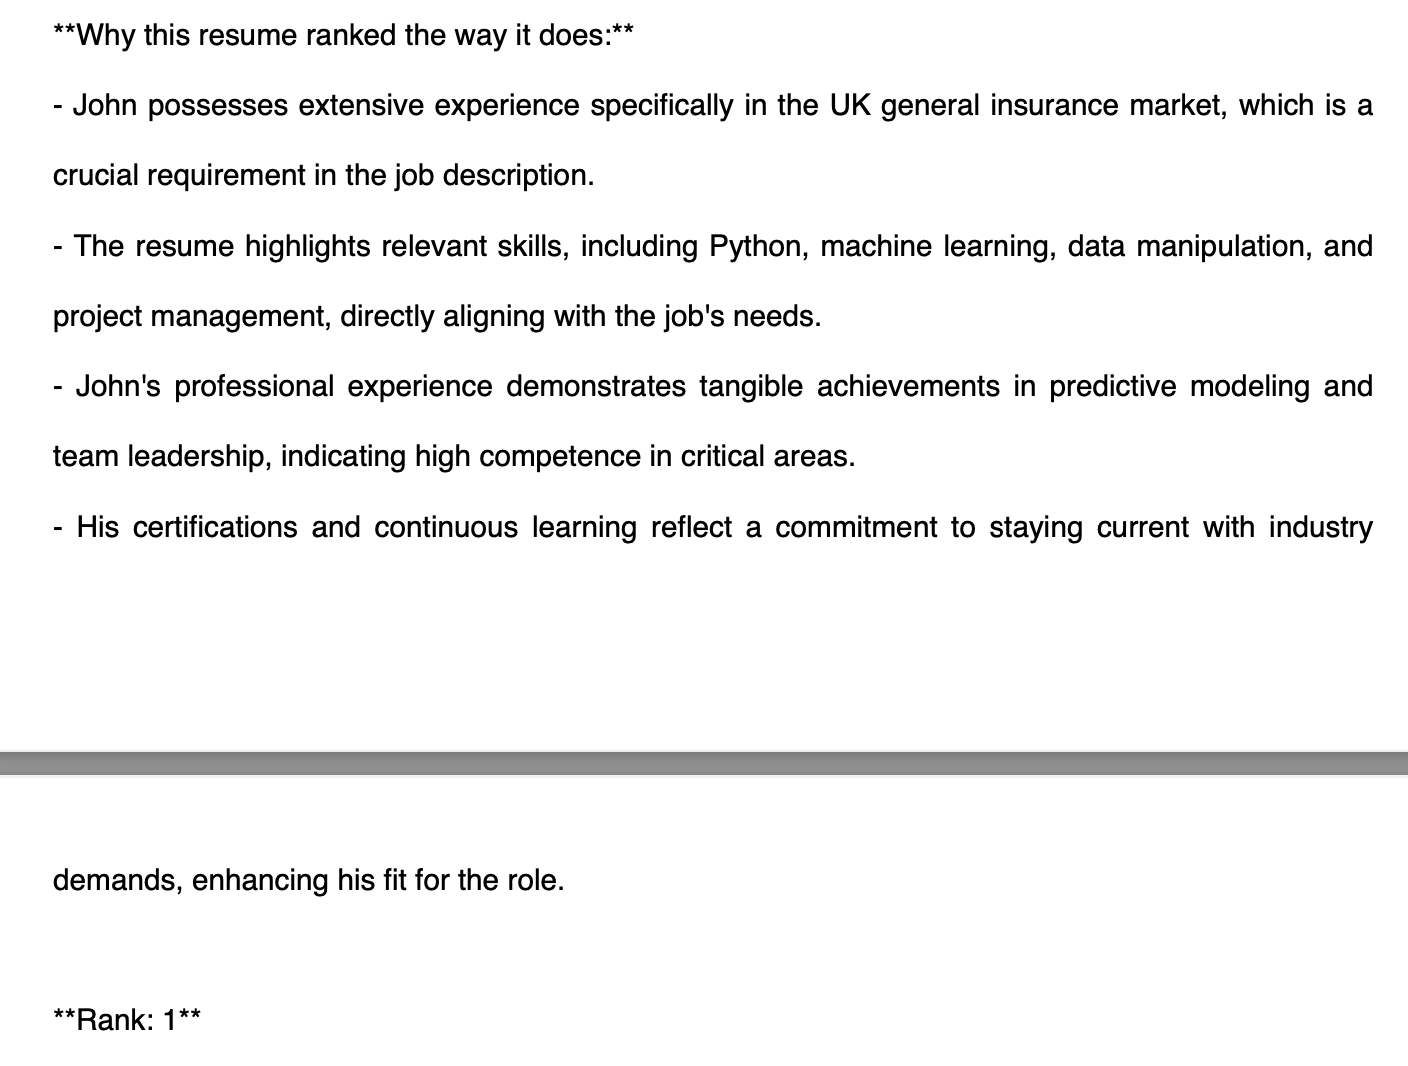

The rank explanation implies that the current promt interprets a good fit based on relevant work experiance, certifications and achievements rather than on skills.

*Next steps:*

Next, we will try to adjust the promt to put more importance on skills rather then other criteria that is not relevant to the skills first approach and our model.

In [17]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Iterate over ranks 1 to 5
    for rank in range(1, 6):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are an AI assistant that generates realistic resumes for candidates in the tech sector.  
The goal is to simulate varying levels of fit between candidates and the provided job description based on skill alignment.
The level of fit should be indicated by numbers from 1 to 5, where:
- **1 = Best Fit** (high alignment of skills and related skills between resume and job description).
- **5 = Lowest Fit** (minimal alignment of skills and related skills between resume and job description).

The ranking **must not depend** on:  
- Level of education.  
- Grades.
- Job titles.
- Work experience.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
**Task:**

For the following job description, generate a unique resume of an individual applicant from the tech sector.
Assign a **ranking from 1 to 5** to the resume based on the following criteria:

**Ranking Criteria:**
1. **Best Fit (Rank 1):**
   - Skills are highly aligned with the job description, including strong direct matches (explicit skills overlap) and complementary skills (implicit patterns).
   - The resume demonstrates high relevance and depth in key skills critical for the job.

2. **Good Fit (Rank 2):**
   - Skills align well, with a mix of direct matches and complementary skills, but slightly less breadth or depth than Rank 1.

3. **Moderate Fit (Rank 3):**
   - Skills cover some relevant areas but may lack critical skills or show limited complementary patterns.

4. **Low Fit (Rank 4):**
   - Few skills align directly with the job, and the complementary patterns are weak or incomplete.

5. **Lowest Fit (Rank 5):**
   - Minimal alignment with the job description, with significant gaps in required skills and little to no complementary patterns.

**Instructions:**
- Create realistic resumes for diverse individuals with:
  - Skills relevant for the technology sector.
  - Unique names and diverse experiences.
  - Realistic KPIs and achievements to validate work experience.
- Ensure higher-ranked resumes demonstrate clear progression in skill alignment, relevance, and relation. Lower-ranked resumes should show clear skill gaps or mismatches.

**Output Requirements:**
- The resume should be between **350-500 words**.
- At the bottom, include bullet points explaining why the resume ranked the way it does.
- End the resume with a line indicating the rank: **Rank: {rank}**.

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{rank}",
            'CV name': f"Candidate_{job_id}_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes4 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes4

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,**Resume** \n**Name:** Aisha Patel \n**Email...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_2,Candidate_1_2,**Resume of Alex Johnson**\n\n**Contact Inform...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,**Resume**\n\n**John Smith**\n\n[Email: john.s...,3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_4,Candidate_1_4,**Resume**\n\n**Name:** Amina Smith \n**Conta...,4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,**Resume**\n\n**Jordan Smith** \n123 Data Lan...,5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,**Resume**\n\n**Name:** Samuel Okafor \n**Ema...,1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_2,Candidate_2_2,**Resume**\n\n**James M. Anderson**\n[Email: j...,2
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,"**Johnathan Lee** \nLondon, United Kingdom \...",3
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_4,Candidate_2_4,"**John Doe** \nLondon, UK | john.doe@email.co...",4
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,"**Emily Johnson** \nLondon, UK \nemily.johns...",5


In [18]:
#%pip install fpdf
import os
from fpdf import FPDF

# Define the folder path to save the PDF files
#folder_path = "/Users/luca/Desktop/Master Thesis/cvs synthetic it.2"
folder_path = "/Users/timg/Desktop/Thesis Docs/Branch_Synth_Data/Synth data by rank/Test_4"

# Function to save text as PDF
def save_as_pdf(text, cv_id):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    # Encode text to latin-1, replacing unsupported characters
    text = text.encode('latin-1', 'replace').decode('latin-1')
    pdf.multi_cell(0, 10, text)
    file_path = os.path.join(folder_path, f"{cv_id}.pdf")
    pdf.output(file_path)

# Iterate over each row in the DataFrame
for index, row in df_resumes3.iterrows():
    cv_text = row["CV"]
    cv_id = row["CV ID"]
    save_as_pdf(cv_text, cv_id)

**Interpretation of results:**

After adjusting the promt to be more skills focused the performance is still not good:
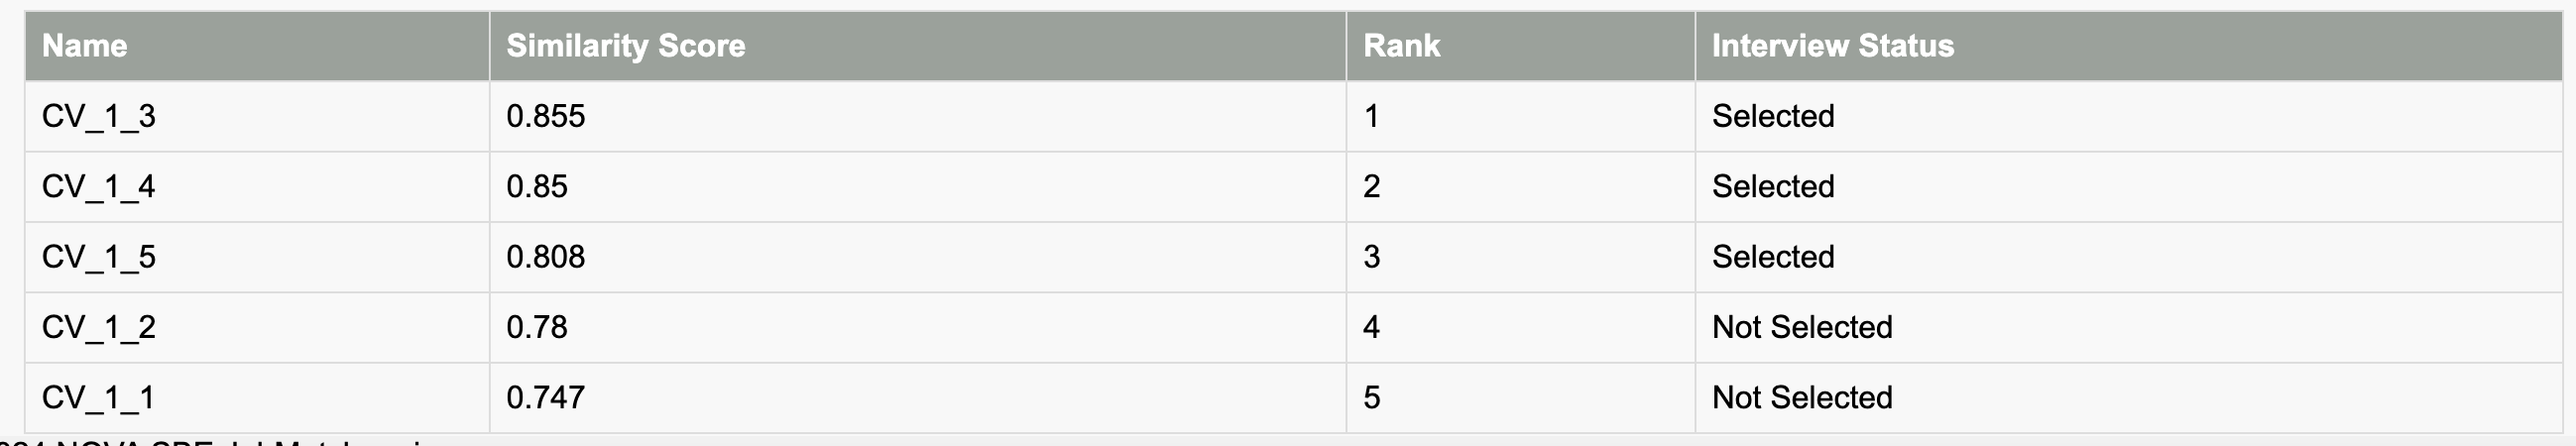

*Next steps:*
1. **Try creating way shorter and more concise system and user messages** focusing only on the alignment of skills.
2. **Try alternative data generation approach:** Instead of ranking 1-5, try generate 6 resumes where 3 represent a good fit and are selected and 3 are a bad fit and are not selected

# Iteration Synthetic Data 23.11

## Concept Changes

- **Perfect Fit as Rank 1**:
    - The perfect fit is now always created as Rank 1.
    - This ensures that the resume with the best alignment of skills always receives the highest rank.

- **Iterative Reduction of Alignment**:
    - The alignment of skills is iteratively reduced with each higher rank.
    - The text of the previous resume is used as a reference for creating the next resume.
    - This ensures a gradual and clear reduction in the alignment of skills.

## Goal

- **Clear Separation of Rank Levels**:
    - The changes aim to ensure that the rank levels are clearly distinguishable from each other.
    - Each rank level shows a distinct progression in the alignment of skills with the job description.
    - This helps in creating realistic resumes that represent different degrees of suitability for the given job.

In [17]:
import os
import pandas as pd

# Set the API and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    previous_resume_text = None
    
    # Iterate over ranks 1 to 5
    for rank in range(1, 6):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are an AI assistant that generates realistic resumes that helps create resumes for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes. 
Do not include the ranking number in the resume text.
"""
        }
        
        # User message with specific instructions
        user_message_content = f"""
**Task:**

Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 5** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 5, where:
- **1 = Perfect Fit** (perfect alignment of skills and related skills between resume and job description).
- **{rank} = Reduced Fit** (reduce the alignment of skills compared to the previous rank).

**Instructions:**
- Create a realistic resume for a candidate with skills relevant to the technology sector.
- Focus on the alignment of skills with the job description.
- Ensure higher-ranked resumes demonstrate clear progression in skill alignment, relevance, and relation. Lower-ranked resumes should show clear skill gaps or mismatches.

**Job Description:**

{job_description}
"""

        if previous_resume_text and rank > 1:
            user_message_content += f"\nPrevious resume text for reference:\n{previous_resume_text}"

        user_message = {
            "role": "user",
            "content": user_message_content
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{rank}",
            'CV name': f"Candidate_{job_id}_{rank}",
            'CV': resume_text,
            'Rank': rank
        })
        
        # Update the previous resume text for the next iteration
        previous_resume_text = resume_text

# Create a DataFrame from the list of generated resumes
df_resumes5 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes5

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,"**John Smith** \n[Your Address] \n[City, Sta...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_2,Candidate_1_2,"**John Smith** \n[Your Address] \n[City, Sta...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,"**John Smith** \n[Your Address] \n[City, Sta...",3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_4,Candidate_1_4,"**John Smith** \n[Your Address] \n[City, Sta...",4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,"**John Smith** \n[Your Address] \n[City, Sta...",5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,"**Resume**\n\n**John Doe** \nLondon, UK \njo...",1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_2,Candidate_2_2,"**Resume**\n\n**John Doe** \nLondon, UK \njo...",2
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,"**Resume**\n\n**John Doe** \nLondon, UK \njo...",3
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_4,Candidate_2_4,"**Resume**\n\n**John Smith** \nLondon, UK \n...",4
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,"**Resume**\n\n**Emily Johnson** \nLondon, UK ...",5


In [18]:
print(df_resumes5[df_resumes5['CV ID'] == 'CV_1_1']['CV'].values[0])


**John Smith**  
[Your Address]  
[City, State, Zip]  
[Your Email]  
[Your Phone Number]  
[LinkedIn Profile]

---

**Professional Summary**  
Results-driven Data Scientist with extensive experience in the UK general insurance sector, specializing in both personal and commercial lines. Proven ability to deliver data-driven insights and develop innovative solutions using cutting-edge analytical techniques and machine learning. Adept at managing complex projects, collaborating with cross-functional teams, and mentoring junior associates. Committed to leveraging deep market knowledge to enhance client relationships and drive business growth.

---

**Experience**  

**Senior Data Scientist**  
XYZ Insurance Group, London, UK  
*June 2018 – Present*  
- Delivered comprehensive data science capabilities reviews that improved decision-making processes across multiple business lines.  
- Developed predictive models and analytic tools using Python, and implemented MLOps practices to streamline

In [20]:
print(df_resumes5[df_resumes5['CV ID'] == 'CV_1_5']['CV'].values[0])


**John Smith**  
[Your Address]  
[City, State, Zip]  
[Your Email]  
[Your Phone Number]  
[LinkedIn Profile]

---

**Professional Summary**  
Experienced Data Scientist with extensive background in the UK general insurance markets, focusing on both personal and commercial lines. Proficient in developing and implementing predictive models and advanced analytics. Demonstrated ability to lead cross-functional teams and manage client relationships effectively.

---

**Experience**  

**Lead Data Scientist**  
XYZ Insurance Solutions, London, UK  
*February 2020 – Present*  
- Spearhead data science capability reviews, delivering cutting-edge analytics solutions for top-tier general insurers.  
- Create predictive models with Python and MLOps, leading to enhanced operational efficiencies for clients.  
- Collaborate with multiple departments to innovate strategies that address complex market challenges.  
- Cultivate trusted advisor relationships with clients, ensuring quality execution o

## Analysis of Differences Between Rank 1 and Rank 5 Resumes

Key Differences
Professional Summary

Rank 1: Detailed and specific.
Rank 5: General and less detailed.

- Experience
    -  Rank 1: Specific job descriptions, technologies, and results.
    -  Rank 5: General job descriptions and results.
- Educatiom 
Similar degrees, but Rank 5 has later graduation dates.
Technical Skills
Rank 1: Specific and relevant.
Rank 5: More general.

Certifications

Rank 1: Relevant.
Rank 5: Less relevant.

Rank 1 matches the job description closely, while Rank 5 does not.

**Differences are mainly in the level of detail and specificity.**

- Current differences are mainly in the depth of descriptions.
- Rank 5 resumes should have skills and experiences completely unrelated to the job description.

***Action for Adjustments***
- Ensure Rank 5 resumes include skills and experiences that do not match the job requirements at all.
- Remove any relevant skills or experiences from Rank 5 resumes to create a clear distinction from Rank 1 resumes.




# Iteration 6



In [22]:
import os
import pandas as pd

# Set the API model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    previous_resume_text = None
    
    # Iterate over ranks 1 to 5
    for rank in range(1, 6):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are an AI assistant that generates realistic resumes that helps create resumes for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes. 
Do not include the ranking number in the resume text.
"""
        }
        
        # User message with specific instructions
        user_message_content = f"""
**Task:**

Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 5** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 5, where:
- **1 = Perfect Fit** (perfect alignment of skills and related skills between resume and job description).
- **{rank} = Reduced Fit** (reduce the alignment of skills compared to the previous rank).

**Instructions:**
- Create a most realistic individual resume for a candidate with skills.
- Focus on the alignment of tech skills with the job description.
- Ensure higher-ranked resumes demonstrate clear progression in skill alignment. Lower-ranked resumes should show clear skill gaps or mismatches.
- For rank 5, ensure the resume includes skills and experiences that are completely unrelated to the job description.

**Job Description:**

{job_description}
"""

        if previous_resume_text and rank > 1:
            user_message_content += f"\nPrevious resume text for reference:\n{previous_resume_text}"

        user_message = {
            "role": "user",
            "content": user_message_content
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{rank}",
            'CV name': f"Candidate_{job_id}_{rank}",
            'CV': resume_text,
            'Rank': rank
        })
        
        # Update the previous resume text for the next iteration
        previous_resume_text = resume_text

# Create a DataFrame from the list of generated resumes
df_resumes6 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes6

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,"**Candidate Name** \n[Your Address] \n[City,...",1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_2,Candidate_1_2,"**Candidate Name** \n[Your Address] \n[City,...",2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,"**Candidate Name** \n[Your Address] \n[City,...",3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_4,Candidate_1_4,"**Candidate Name** \n[Your Address] \n[City,...",4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,"**Candidate Name** \n[Your Address] \n[City,...",5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,"**Resume**\n\n**John Doe** \nLondon, UK \njo...",1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_2,Candidate_2_2,"**Resume**\n\n**Jane Smith** \nLondon, UK \n...",2
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,"**Resume**\n\n**John Doe** \nLondon, UK \njo...",3
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_4,Candidate_2_4,"**Resume**\n\n**Jane Smith** \nLondon, UK \n...",4
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,"**Resume**\n\n**John Doe** \nLondon, UK \njo...",5




**Candidate Name**  
[Your Address]  
[City, Post Code]  
[Your Email]  
[Your Phone Number]  

---

**Professional Summary**  
Results-driven Data Scientist with robust experience in the UK general insurance sector. Proficient in building predictive models, leveraging advanced data analytics, and collaborating across teams to drive innovative solutions. Strong communicator with a passion for project management and mentoring junior associates.

**Education**  
Master of Science in Data Science  
University of Glasgow, Glasgow, UK  
Graduated: 2021  

Bachelor of Science in Mathematics  
University of Warwick, Coventry, UK  
Graduated: 2019  

**Skills**  
- Data Science & Analytics  
- Predictive Modeling  
- Machine Learning & AI  
- Data Manipulation (Pandas, NumPy)  
- Proficient in Python and R  
- Version Control with Git  
- Familiar with MLOps concepts  
- Experience with Azure and AWS  
- Strong Project Management Skills  
- Excellent Communication Skills  
- Team Leadership & Mentoring  

**Professional Experience**  

**Data Scientist**  
ABC Insurance Solutions, London, UK  
June 2021 - Present  
- Delivered data science capability reviews and implemented predictive models for both commercial and personal lines in the insurance market.
- Developed innovative analytical tools and collaborated with cross-functional teams to address challenges faced by clients effectively.
- Fostered strong relationships with clients, enhancing communications and ensuring high-level project execution.

**Data Analyst**  
DEF Analytics Firm, London, UK  
August 2019 - May 2021  
- Created and refined predictive models using advanced machine learning techniques, contributing to improved pricing strategies across various business lines.
- Supported project management efforts by maintaining timelines and facilitating communication between client stakeholders and technical teams.

**Data Science Intern**  
GHI Data Solutions, London, UK  
June 2018 - August 2018  
- Assisted in data manipulation and analysis using Python, contributing to team projects aimed at delivering data-driven solutions for clients. 

---

**Ranking:** 1

### Generated Resume for Rank 5 

**Candidate Name**  
[Your Address]  
[City, Post Code]  
[Your Email]  
[Your Phone Number]  

---

**Professional Summary**  
Results-driven Data Scientist with robust experience in the UK general insurance sector. Proficient in building predictive models, leveraging advanced data analytics, and collaborating across teams to drive innovative solutions. Strong communicator with a passion for project management and mentoring junior associates.

**Education**  
Master of Science in Data Science  
University of Glasgow, Glasgow, UK  
Graduated: 2021  

Bachelor of Science in Mathematics  
University of Warwick, Coventry, UK  
Graduated: 2019  

**Skills**  
- Data Science & Analytics  
- Predictive Modeling  
- Machine Learning & AI  
- Data Manipulation (Pandas, NumPy)  
- Proficient in Python and R  
- Version Control with Git  
- Familiar with MLOps concepts  
- Experience with Azure and AWS  
- Strong Project Management Skills  
- Excellent Communication Skills  
- Team Leadership & Mentoring  

**Professional Experience**  

**Data Scientist**  
ABC Insurance Solutions, London, UK  
June 2021 - Present  
- Delivered data science capability reviews and implemented predictive models for both commercial and personal lines in the insurance market.
- Developed innovative analytical tools and collaborated with cross-functional teams to address challenges faced by clients effectively.
- Fostered strong relationships with clients, enhancing communications and ensuring high-level project execution.

**Data Analyst**  
DEF Analytics Firm, London, UK  
August 2019 - May 2021  
- Created and refined predictive models using advanced machine learning techniques, contributing to improved pricing strategies across various business lines.
- Supported project management efforts by maintaining timelines and facilitating communication between client stakeholders and technical teams.

**Data Science Intern**  
GHI Data Solutions, London, UK  
June 2018 - August 2018  
- Assisted in data manipulation and anal

### Analysis of the Current Prompting Approach
**Iterative** Approach:

The current approach attempts to gradually reduce the relevance of skills and experiences to create different ranks.
This leads to inconsistent and not clearly distinguishable differences between the ranks.
Problems:

- **Unclear Differences:** The differences between the ranks are often subtle and not distinct enough to establish a clear hierarchy.
- **Similar Skills:** Many skills and experiences overlap between the ranks, making differentiation difficult.
- **Lack of Irrelevance**: The approach does not ensure that lower ranks (e.g., rank 5) contain skills and experiences that are completely irrelevant to the job description.
Example:

Rank 1: Contains specific and relevant skills like MLOps and Radar Software.
Rank 5: Contains similar skills like MLOps and only slightly different skills like R, without showing clear irrelevance.
Conclusion
The current iterative approach to downgrading skills and experiences does not result in clearly distinguishable and hierarchically ordered resumes. A new approach should be developed that ensures lower ranks contain significantly less relevant or even irrelevant skills and experiences.

In [26]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Iterate over ranks 1 to 5
    for rank in range(1, 6):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the worlds best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 5** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 5, where:
- **1 = Perfect Fit** (perfect alignment of skills and related skills between resume and job description).
- **5 = No Fit** (no alignment of skills and related skills between resume and job description - the candidates comes from another field).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{rank}",
            'CV name': f"Candidate_{job_id}_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes7 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes7

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,**Resume for Jane Doe**\n\n**Contact Informati...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_2,Candidate_1_2,**Resume:**\n\n**Name:** Emily Johnson \n**Em...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,**Resume**\n\n**John Doe** \n[Your Address] ...,3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_4,Candidate_1_4,**Candidate Name:** Jane Doe \n**Contact Info...,4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,**Candidate Name:** Sarah Thompson \n**Addres...,5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,**Candidate Name:** John Smith \n**Contact In...,1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_2,Candidate_2_2,**Resume of Alex Johnson** \n123 Tech Lane \...,2
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,**Candidate Name:** Alex Johnson \n**Phone:**...,3
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_4,Candidate_2_4,**Candidate Name:** Samuel Johnson \n**Email:...,4
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,**Candidate Name:** Sarah Thompson \n**Addres...,5


In [28]:
rank_1_cv = df_resumes7[(df_resumes7['Job Description ID'] == 1) & (df_resumes7['Rank'] == 1)]['CV'].values[0]
rank_5_cv = df_resumes7[(df_resumes7['Job Description ID'] == 1) & (df_resumes7['Rank'] == 5)]['CV'].values[0]

print("CV for Rank 1:")
print(rank_1_cv)

print("\nCV for Rank 5:")
print(rank_5_cv)


CV for Rank 1:
**Resume for Jane Doe**

**Contact Information:**
- Jane Doe  
- Email: jane.doe@email.com  
- Phone: (123) 456-7890  
- LinkedIn: linkedin.com/in/janedoe  

---

**Professional Summary:**
Enthusiastic Data Scientist with over 5 years of experience in the UK general insurance sector, specializing in both personal and commercial lines. Proven expertise in developing predictive models, leveraging machine learning techniques, and driving data-driven solutions to enhance business performance. Strong leadership and project management skills combined with a collaborative approach to deliver value to clients.

---

**Professional Experience:**

**Data Scientist**  
ABC Insurance Company, London, UK  
May 2018 - Present  
- Conducted comprehensive data science capability reviews, significantly improving operational efficiencies across the organization.
- Developed and implemented predictive models and analytic tools using Python, effectively addressing key business issues.
- Col


kurze analyse dass user und system message zu unkonkret sind und zu wenig informationen enthalten

In [30]:
import os
import pandas as pd

# Set the API key and model name
MODEL = "gpt-4o-mini"
api_key = os.getenv("OPENAI_KEY")

# List to store the generated resumes
generated_resumes_list = []

# Iterate over each job description
for index, row in df_filtered.iterrows():
    job_id = row['Job ID']
    job_title = row['Job Title']
    job_description = row['JD']
    
    # Iterate over ranks 1 to 5
    for rank in range(1, 6):
        # System message providing context
        system_message = {
            "role": "system",
            "content": """
You are the world's best AI HR EXPERT that generates realistic resumes of different individuals which could be real persons, for a given job description from the tech sector. 
The goal is to simulate clearly differentiable levels of fit between candidates and the provided job description only based on skill alignment.
The ranking **must not depend** on any other factor except of the skills mentioned in the resume and the job description. 
Do not include any note or explanation of how you generate the resumes.
"""
        }
        
        # User message with specific instructions
        user_message = {
            "role": "user",
            "content": f"""
Generate a resume for a candidate applying for the following tech job. Assign a **ranking from 1 to 5** to the resume based on the alignment of skills.

The level of fit should be clearly separable to each other and labeled with a number from 1 to 5, where:
- **1 = Perfect Fit** (perfect alignment of skills and related skills between resume and job description).
- **5 = No Fit** (no alignment of skills and related skills between resume and job description - the candidate comes from another field entirely, such as marketing or finance).

**Job Description:**

{job_description}
"""
        }
        
        # Invoke the client's chat completion method
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[
                system_message,
                user_message
            ]
        )
        
        # Extract the generated resume
        resume_text = completion.choices[0].message.content.strip()
        
        # Append the resume and associated data to the list
        generated_resumes_list.append({
            'Job Description ID': job_id,
            'Job Title': job_title,
            'Job description text (our input)': job_description,
            'CV ID': f"CV_{job_id}_{rank}",
            'CV name': f"Candidate_{job_id}_{rank}",
            'CV': resume_text,
            'Rank': rank
        })

# Create a DataFrame from the list of generated resumes
df_resumes8 = pd.DataFrame(generated_resumes_list)

# Display the DataFrame
df_resumes8

,Job Description ID,Job Title,Job description text (our input),CV ID,CV name,CV,Rank
0,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_1,Candidate_1_1,**Resume: John Smith**\n\n**Contact Informatio...,1
1,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_2,Candidate_1_2,**Candidate Resume: John Smith**\n\n**Contact ...,2
2,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_3,Candidate_1_3,**Candidate Resume**\n\n**Name:** Sarah Thomps...,3
3,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_4,Candidate_1_4,**Resume for Candidate A**\n\n**John Smith** ...,4
4,1,"Senior Data Scientist, WTW, London",\nFull job description\n\nDescription\nWe are ...,CV_1_5,Candidate_1_5,**Candidate Name:** John Smith \n**Location:*...,5
5,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_1,Candidate_2_1,**Candidate Name**: Alex Johnson \n**Contact ...,1
6,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_2,Candidate_2_2,**Resume: John Doe**\n\n**Contact Information:...,2
7,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_3,Candidate_2_3,**Resume: John Doe**\n\n**Contact Information:...,3
8,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_4,Candidate_2_4,**Candidate Name:** Alice Johnson \n**Contact...,4
9,2,"Software Engineer II, Android, Microsoft, London",\nFull job description\nOur SwiftKey app empow...,CV_2_5,Candidate_2_5,**Candidate Name:** John Smith \n**Address:**...,5


In [32]:
# Filtern der Zeilen mit JD1 und Rank 1
cv_rank1 = df_resumes8[(df_resumes8['Job Description ID'] == 1) & (df_resumes8['Rank'] == 1)]
# Drucken des CVs mit Rank 1
print(cv_rank1['CV'].values[0])

# Filtern der Zeilen mit JD1 und Rank 5
cv_rank5 = df_resumes8[(df_resumes8['Job Description ID'] == 1) & (df_resumes8['Rank'] == 5)]
# Drucken des CVs mit Rank 5
print(cv_rank5['CV'].values[0])



**Resume: John Smith**

**Contact Information:**
- Phone: (555) 123-4567
- Email: john.smith@email.com
- LinkedIn: linkedin.com/in/johnsmith

---

**Professional Summary:**
Data Scientist with over 5 years of experience in the UK general insurance market specializing in commercial and personal lines. Proven track record in delivering best-in-class data science solutions and managing complex projects. Strong expertise in machine learning, data manipulation, and predictive modeling with a self-starter attitude and excellent interpersonal skills.

---

**Work Experience:**

**Data Scientist**  
XYZ Insurance Solutions, London, UK  
January 2019 – Present  
- Led the development of predictive models that increased sales by 15% through enhanced underwriting processes.  
- Collaborated with cross-functional teams to build analytic tools leveraging machine learning and AI technologies.  
- Managed substantial work streams resulting in a 20% improvement in project delivery timelines and client